In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product

import models.original_models as original_models
import models.models_3d_atomics_on_variate_to_concepts as new_models
from vasopressor.preprocess_helpers import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_selection

gpu_id = int(subprocess.check_output('nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader | nl -v 0 | sort -nrk 2 | cut -f 1 | head -n 1 | xargs', shell=True, text=True))
device = torch.device(f'cuda:{gpu_id}') if torch.cuda.is_available else torch.device('cpu')
print("current device", device)

current device cuda:15


In [2]:
X, Y_logits, changing_vars, _ = myPreprocessed()
print(X.shape)
print(Y_logits.shape) # (logit, original)
y = Y_logits[:, 1, None]
print(y.shape)
print(len(changing_vars), changing_vars)


(29137, 6, 62)
(29137, 2)
(29137, 1)
27 ['dbp', 'fio2', 'GCS', 'hr', 'map', 'sbp', 'spontaneousrr', 'spo2', 'temp', 'bun', 'magnesium', 'platelets', 'sodium', 'alt', 'hct', 'po2', 'ast', 'potassium', 'wbc', 'bicarbonate', 'creatinine', 'lactate', 'pco2', 'glucose', 'inr', 'hgb', 'bilirubin_total']


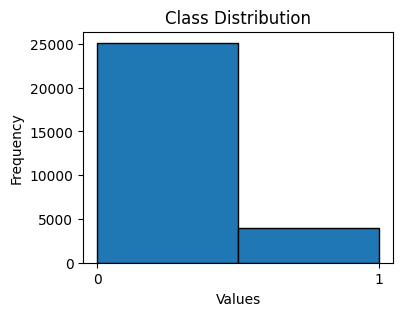

In [3]:
plt.figure(figsize=(4, 3))
plt.hist(y, bins=len(np.unique(y)), edgecolor='black')
plt.xticks(np.unique(y))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

In [4]:
def preprocess_data(_X, _Y_logits, output_dim, batch_size = 512, random_state = 1):
    
    # ## target
    y = _Y_logits
    if output_dim == 1:
        y = _Y_logits[:, 1, None]
    
    y_unique = np.unique(y)
    num_classes = len(y_unique)
    
    # # class weights
    class_weights = compute_class_weight(class_weight="balanced", classes=y_unique, y=_Y_logits[:, 1])
    class_weights = torch.tensor(class_weights)
    
    if output_dim == 1:
        class_weights = class_weights[1]/class_weights[0] # == pos / neg   # get ONLY positive sample weights
    
    
    # split 60/20/20 %
    X_train, X_test, y_train, y_test = train_test_split(_X, y, test_size = 0.40, random_state = random_state, stratify = y)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.50, random_state = random_state, stratify = y_test)

    # tensor
    X_train_pt = torch.tensor(X_train, dtype=torch.float32)
    y_train_pt = torch.tensor(y_train)

    X_val_pt = torch.tensor(X_val, dtype=torch.float32)
    y_val_pt = torch.tensor(y_val)

    X_test_pt = torch.tensor(X_test, dtype=torch.float32)
    y_test_pt = torch.tensor(y_test)
    
    # dataloader
    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4, pin_memory=True)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = X_val_pt.shape[0], shuffle=False, num_workers=4, pin_memory=True)

    test_dataset = TensorDataset(X_test_pt, y_test_pt)
    test_loader = DataLoader(test_dataset, batch_size = X_test_pt.shape[0], shuffle=False, num_workers=4, pin_memory=True)
    
    
    return train_loader, val_loader, test_loader, class_weights, num_classes


In [5]:
train_loader, val_loader, test_loader, class_weights, num_classes = preprocess_data(X, Y_logits, 1)

print(class_weights, num_classes)

for a,b in train_loader:
    print(a.shape, a.device)
    print(b.shape, b.device)
    break

len(train_loader)

tensor(6.2752, dtype=torch.float64) 2
torch.Size([512, 6, 62]) cpu
torch.Size([512, 1]) cpu


35

In [6]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_metrics(history, n_concepts_list):
    plt.plot(history[:, 0], history[:, 2], label=f'AUC')
    plt.plot(history[:, 0], history[:, 3], label=f'ACC')
    plt.plot(history[:, 0], history[:, 4], label=f'F1')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title('Plot of Concepts vs Criteria')
    plt.xticks(n_concepts_list)

    plt.legend()
    plt.show()

def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "auc", "acc", "f1"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["auc"], label='AUC')
    plt.plot(mean_atomics.index, mean_atomics["acc"], label='ACC')
    plt.plot(mean_atomics.index, mean_atomics["f1"], label='F1')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["auc"], label='AUC')
    plt.plot(mean_concepts.index, mean_concepts["acc"], label='ACC')
    plt.plot(mean_concepts.index, mean_concepts["f1"], label='F1')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()


In [7]:
def initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim, 
                    use_indicators, use_fixes, use_only_last_timestep, top_k=''):
    model = original_models.CBM(input_dim = input_dim, 
                                changing_dim = changing_dim, 
                                seq_len = seq_len,
                                num_concepts = n_concepts,
                                use_indicators = use_indicators,
                                use_fixes = use_fixes,
                                use_only_last_timestep = use_only_last_timestep,
                                opt_lr = 1e-3,
                                opt_weight_decay = 1e-5,
                                l1_lambda=1e-3,
                                cos_sim_lambda=1e-2,
                                output_dim = output_dim,
                                top_k=top_k,
                                device = device
                                )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim, 
                                 use_summaries_for_atomics, use_indicators, use_fixes, top_k=''):
    model = new_models.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            num_atomics= n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            use_indicators = use_indicators,
                            use_fixes = use_fixes,
                            opt_lr = 1e-3,
                            opt_weight_decay = 1e-5,
                            l1_lambda=1e-3,
                            cos_sim_lambda=1e-2,
                            output_dim = output_dim,
                            top_k=top_k,
                            device = device
                            )
    model = model.to(device)
    return model


In [8]:

auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)
conf_matrix = ConfusionMatrix(task="binary").to(device)

seq_len = X.shape[1]
changing_dim = len(changing_vars)
input_dim = X.shape[2]

print(changing_dim, input_dim, seq_len)

random_seed = 1
set_seed(random_seed)


27 62 6


In [9]:
config = {
    "n_concepts_list": list(range(4, 5, 1)),
    "use_indicators": [True, False],
    "use_fixes": [False, True],
    "output_dim": [2], #1
    "use_only_last_timestep": [True, False],
}

all_config_permutations_og = list(product(*config.values()))
print(len(all_config_permutations_og))
all_config_permutations_og

8


[(4, True, False, 2, True),
 (4, True, False, 2, False),
 (4, True, True, 2, True),
 (4, True, True, 2, False),
 (4, False, False, 2, True),
 (4, False, False, 2, False),
 (4, False, True, 2, True),
 (4, False, True, 2, False)]

## Original

In [10]:
experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original/"
model_path = experiment_folder + "vaso_c{}_ind{}_fixes{}_onlylasttimestep{}_output_dim{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [11]:
histories_original = []

for i, (n_concepts, use_indicators, use_fixes, output_dim, use_only_last_timestep) in enumerate(all_config_permutations_og):
    print(i, n_concepts, use_indicators, use_fixes, output_dim, use_only_last_timestep)
    
    train_loader, val_loader, test_loader, class_weights, num_classes = preprocess_data(X, Y_logits, output_dim)
    
    model = initializeModel(n_concepts=n_concepts, input_dim=input_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=output_dim, 
                            use_indicators=use_indicators, use_fixes=use_fixes, use_only_last_timestep=use_only_last_timestep)
    
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(n_concepts, use_indicators, use_fixes, use_only_last_timestep, output_dim), max_epochs=10000)
    
    model.eval()
    with torch.inference_mode():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            probs = model.forward_probabilities(Xb)
            
            auc = auroc_metric(probs, yb).item()
            acc = accuracy_metric(probs, yb).item()
            f1 = f1_metric(probs, yb).item()
            # conf_matrix(probs, yb)
        auc = auroc_metric.compute().item()
        acc = accuracy_metric.compute().item()
        f1 = f1_metric.compute().item()
        # conf_matrix.plot()
        # plt.show()
        auroc_metric.reset()
        accuracy_metric.reset()
        # conf_matrix.reset()
        f1_metric.reset()
    
    history = ["original", i, model.val_losses[-1], auc, acc, f1]
    print(history)
    histories_original.append(np.array(history))
    
    # plot_losses(model.train_losses, model.val_losses)
    
histories_original = np.array(histories_original)
histories_original.shape


0 4 True False 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c4_indTrue_fixesFalse_onlylasttimestepTrue_output_dim2.pt
['original', 0, 0.5197964310646057, 0.91069096326828, 0.8326754570007324, 0.8411534428596497]
1 4 True False 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c4_indTrue_fixesFalse_onlylasttimestepFalse_output_dim2.pt
['original', 1, 0.5231447815895081, 0.9181749820709229, 0.843058168888092, 0.8501924872398376]
2 4 True True 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c4_indTrue_fixesTrue_onlylasttimestepTrue_output_dim2.pt
['original', 2, 0.5176288485527039, 0.912331223487854, 0.8375664949417114, 0.8448233604431152]
3 4 True True 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c4_indTrue_fixesTrue_onlylasttimestepFalse_output_dim2.pt
['original', 3, 0.5236897468566895, 0.9159983992576599, 0.838424563407898, 0.845920979976654]
4 4 False False 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c4_indFalse_fixesFalse_onlylasttimestepTrue_output_dim2.pt
['original', 4, 0.5202323198318481, 0.9149949550628662, 0.8411704301834106, 0.849033534526825]
5 4 False False 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c4_indFalse_fixesFalse_onlylasttimestepFalse_output_dim2.pt
['original', 5, 0.526611864566803, 0.9185498952865601, 0.8415994644165039, 0.8493061065673828]
6 4 False True 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c4_indFalse_fixesTrue_onlylasttimestepTrue_output_dim2.pt
['original', 6, 0.522624135017395, 0.9115630388259888, 0.8345632553100586, 0.8426892757415771]
7 4 False True 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c4_indFalse_fixesTrue_onlylasttimestepFalse_output_dim2.pt
['original', 7, 0.524418294429779, 0.9150282144546509, 0.839625895023346, 0.8469161987304688]


(8, 6)

In [12]:
# plot
# plot_metrics(histories_original, n_concepts_list)


## Atomics

In [13]:
config = {
    "n_atomics_list": [10, 30, 100],
    "n_concepts_list": list(range(4, 5, 1)),
    "use_indicators": [True, False],
    "use_fixes": [False, True],
    "output_dim": [2], #1
    # "use_only_last_timestep": [True, False],
    "use_summaries_for_atomics": [True, False],
}

all_config_permutations_atomics = list(product(*config.values()))
print(len(all_config_permutations_atomics))
all_config_permutations_atomics

24


[(10, 4, True, False, 2, True),
 (10, 4, True, False, 2, False),
 (10, 4, True, True, 2, True),
 (10, 4, True, True, 2, False),
 (10, 4, False, False, 2, True),
 (10, 4, False, False, 2, False),
 (10, 4, False, True, 2, True),
 (10, 4, False, True, 2, False),
 (30, 4, True, False, 2, True),
 (30, 4, True, False, 2, False),
 (30, 4, True, True, 2, True),
 (30, 4, True, True, 2, False),
 (30, 4, False, False, 2, True),
 (30, 4, False, False, 2, False),
 (30, 4, False, True, 2, True),
 (30, 4, False, True, 2, False),
 (100, 4, True, False, 2, True),
 (100, 4, True, False, 2, False),
 (100, 4, True, True, 2, True),
 (100, 4, True, True, 2, False),
 (100, 4, False, False, 2, True),
 (100, 4, False, False, 2, False),
 (100, 4, False, True, 2, True),
 (100, 4, False, True, 2, False)]

In [14]:
experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/atomics/"
model_path = experiment_folder + "vaso_a{}_c{}_ind{}_fixes{}_output_dim{}_summaries{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [15]:
history_atomics = []

for i, (n_atomics, n_concepts, use_indicators, use_fixes, output_dim, use_summaries_for_atomics) in enumerate(all_config_permutations_atomics):
    print(i, n_atomics, n_concepts, use_indicators, use_fixes, output_dim, use_summaries_for_atomics)
    
    train_loader, val_loader, test_loader, class_weights, num_classes = preprocess_data(X, Y_logits, output_dim)
    
    model = initializeModel_with_atomics(n_atomics=n_atomics, n_concepts=n_concepts, input_dim=input_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=output_dim, 
                                         use_summaries_for_atomics=use_summaries_for_atomics, use_indicators=use_indicators, use_fixes=use_fixes)
    
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(n_atomics, n_concepts, use_indicators, use_fixes, output_dim, use_summaries_for_atomics), max_epochs=10000)
    
    model.eval()
    with torch.inference_mode():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            probs = model.forward_probabilities(Xb)
            
            auc = auroc_metric(probs, yb).item()
            acc = accuracy_metric(probs, yb).item()
            f1 = f1_metric(probs, yb).item()
            # conf_matrix(probs, yb)
        auc = auroc_metric.compute().item()
        acc = accuracy_metric.compute().item()
        f1 = f1_metric.compute().item()
        # conf_matrix.plot()
        # plt.show()
        auroc_metric.reset()
        accuracy_metric.reset()
        # conf_matrix.reset()
        f1_metric.reset()

    history = ["CBM atomics", i, model.val_losses[-1], auc, acc, f1]
    print(history)
    history_atomics.append(np.array(history))
    
    # plot_losses(model.train_losses, model.val_losses)

    
history_atomics = np.array(history_atomics)
history_atomics.shape


0 10 4 True False 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_indTrue_fixesFalse_output_dim2_summariesTrue.pt
['CBM atomics', 0, 0.5313735008239746, 0.9138913750648499, 0.8373948931694031, 0.8451417684555054]
1 10 4 True False 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_indTrue_fixesFalse_output_dim2_summariesFalse.pt
['CBM atomics', 1, 0.5765553116798401, 0.9044694900512695, 0.8504376411437988, 0.8548104763031006]
2 10 4 True True 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_indTrue_fixesTrue_output_dim2_summariesTrue.pt
['CBM atomics', 2, 0.533596396446228, 0.9134929776191711, 0.8369658589363098, 0.844897985458374]
3 10 4 True True 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_indTrue_fixesTrue_output_dim2_summariesFalse.pt
['CBM atomics', 3, 0.572110116481781, 0.905956506729126, 0.8410845994949341, 0.8491610884666443]
4 10 4 False False 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_indFalse_fixesFalse_output_dim2_summariesTrue.pt
['CBM atomics', 4, 0.5387791991233826, 0.9162099957466125, 0.8392826318740845, 0.8472142815589905]
5 10 4 False False 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_indFalse_fixesFalse_output_dim2_summariesFalse.pt
['CBM atomics', 5, 0.6165825128555298, 0.9101204872131348, 0.858503520488739, 0.863142192363739]
6 10 4 False True 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
 15%|█▍        | 1460/10000 [43:25<4:14:02,  1.78s/ epoch, Train Loss=0.49683, Val Loss=0.53067, Best Val Loss=0.52991]

Early Stopped


['CBM atomics', 6, 0.5306442379951477, 0.9139459133148193, 0.8373090624809265, 0.844946026802063]
7 10 4 False True 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  3%|▎         | 320/10000 [07:56<4:00:06,  1.49s/ epoch, Train Loss=0.60574, Val Loss=0.63915, Best Val Loss=0.62633]

Early Stopped


['CBM atomics', 7, 0.6353075504302979, 0.9069522619247437, 0.8546422123908997, 0.8582426905632019]
8 30 4 True False 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_indTrue_fixesFalse_output_dim2_summariesTrue.pt
['CBM atomics', 8, 0.5467365980148315, 0.9132466316223145, 0.8349064588546753, 0.8434499502182007]
9 30 4 True False 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_indTrue_fixesFalse_output_dim2_summariesFalse.pt
['CBM atomics', 9, 0.8273098468780518, 0.9106552600860596, 0.8584176898002625, 0.862500011920929]
10 30 4 True True 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_indTrue_fixesTrue_output_dim2_summariesTrue.pt
['CBM atomics', 10, 0.5450490117073059, 0.9142844676971436, 0.8366225957870483, 0.8446728587150574]
11 30 4 True True 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_indTrue_fixesTrue_output_dim2_summariesFalse.pt
['CBM atomics', 11, 0.8207803964614868, 0.9049814939498901, 0.8400549292564392, 0.8473632335662842]
12 30 4 False False 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_indFalse_fixesFalse_output_dim2_summariesTrue.pt
['CBM atomics', 12, 0.6433839797973633, 0.9165804386138916, 0.8412562012672424, 0.8491765856742859]
13 30 4 False False 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_indFalse_fixesFalse_output_dim2_summariesFalse.pt
['CBM atomics', 13, 1.2209855318069458, 0.9029526710510254, 0.8432297706604004, 0.8496419787406921]
14 30 4 False True 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  8%|▊         | 760/10000 [20:08<4:04:56,  1.59s/ epoch, Train Loss=0.61647, Val Loss=0.65037, Best Val Loss=0.64891]

Early Stopped


['CBM atomics', 14, 0.6501591801643372, 0.9152473211288452, 0.838167130947113, 0.8457133769989014]
15 30 4 False True 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  6%|▌         | 610/10000 [15:19<3:55:47,  1.51s/ epoch, Train Loss=1.19525, Val Loss=1.21282, Best Val Loss=1.21073]

Early Stopped


['CBM atomics', 15, 1.213905692100525, 0.903346061706543, 0.8537840843200684, 0.8590103983879089]
16 100 4 True False 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a100_c4_indTrue_fixesFalse_output_dim2_summariesTrue.pt
['CBM atomics', 16, 1.7654085159301758, 0.9176620244979858, 0.8429723978042603, 0.8500000238418579]
17 100 4 True False 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a100_c4_indTrue_fixesFalse_output_dim2_summariesFalse.pt
['CBM atomics', 17, 4.45297384262085, 0.9060219526290894, 0.84425950050354, 0.850037157535553]
18 100 4 True True 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a100_c4_indTrue_fixesTrue_output_dim2_summariesTrue.pt
['CBM atomics', 18, 1.798357367515564, 0.9168349504470825, 0.8449459671974182, 0.8520429134368896]
19 100 4 True True 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a100_c4_indTrue_fixesTrue_output_dim2_summariesFalse.pt
['CBM atomics', 19, 4.391152858734131, 0.909683108329773, 0.8465762734413147, 0.8524996042251587]
20 100 4 False False 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a100_c4_indFalse_fixesFalse_output_dim2_summariesTrue.pt
['CBM atomics', 20, 2.689943790435791, 0.916722297668457, 0.839625895023346, 0.8473662734031677]
21 100 4 False False 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a100_c4_indFalse_fixesFalse_output_dim2_summariesFalse.pt
['CBM atomics', 21, 8.577739715576172, 0.9088339805603027, 0.8491504788398743, 0.8542046546936035]
22 100 4 False True 2 True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
 10%|█         | 1000/10000 [26:50<4:01:38,  1.61s/ epoch, Train Loss=2.64849, Val Loss=2.67665, Best Val Loss=2.67664]

Early Stopped


['CBM atomics', 22, 2.681684970855713, 0.8922815322875977, 0.8103655576705933, 0.8218891024589539]
23 100 4 False True 2 False


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  2%|▏         | 230/10000 [06:04<4:18:00,  1.58s/ epoch, Train Loss=8.58093, Val Loss=8.60285, Best Val Loss=8.59319] 

Early Stopped


['CBM atomics', 23, 8.597587585449219, 0.9080427885055542, 0.8589325547218323, 0.8634097576141357]


(24, 6)

In [16]:
# plot_atomics_concepts_metric(history_atomics, "title")


In [17]:
columns=["type", "config", "val_loss", "auc", "acc", "f1"]
dtypes = {'type': str, 'config': int, 'val_loss': float, 'auc': float, 'acc': float, 'f1': float}

df_og = pd.DataFrame(histories_original, columns=columns).astype(dtypes)
matching_values = [str(all_config_permutations_og[val]) for val in df_og['config']]
df_og["config2"] = matching_values

df_atomics = pd.DataFrame(history_atomics, columns=columns).astype(dtypes)
matching_values = [str(all_config_permutations_atomics[val]) for val in df_atomics['config']]
df_atomics["config2"] = matching_values
df_atomics["config"] = df_atomics["config"].astype(int)

result_df = pd.concat([df_og, df_atomics], ignore_index=True)

In [18]:
for col in result_df.columns[3:6]:
    baseline = result_df[(result_df['type'] == 'original') & (result_df['config'] == 0)][col].values[0]
    print(baseline)
    result_df[f'{col}_abs_imp'] = result_df[col] - baseline
    result_df[f'{col}_rel_imp'] = result_df[f'{col}_abs_imp'] / baseline
# result_df

0.91069096326828
0.8326754570007324
0.8411534428596497


In [19]:
result_df.sort_values(by='auc_abs_imp', ascending=False)
# atomics: atomics, concepts, use_indicators, use_fixes, output_dim, use_summaries_for_atomics
# original: concepts, use_indicators, use_fixes, output_dim, use_only_last_timestep


,type,config,val_loss,auc,acc,f1,config2,auc_abs_imp,auc_rel_imp,acc_abs_imp,acc_rel_imp,f1_abs_imp,f1_rel_imp
5,original,5,0.526612,0.918550,0.841599,0.849306,"(4, False, False, 2, False)",0.007859,0.008630,0.008924,0.010717,0.008153,0.009692
1,original,1,0.523145,0.918175,0.843058,0.850192,"(4, True, False, 2, False)",0.007484,0.008218,0.010383,0.012469,0.009039,0.010746
24,CBM atomics,16,1.765409,0.917662,0.842972,0.850000,"(100, 4, True, False, 2, True)",0.006971,0.007655,0.010297,0.012366,0.008847,0.010517
26,CBM atomics,18,1.798357,0.916835,0.844946,0.852043,"(100, 4, True, True, 2, True)",0.006144,0.006747,0.012271,0.014736,0.010889,0.012946
28,CBM atomics,20,2.689944,0.916722,0.839626,0.847366,"(100, 4, False, False, 2, True)",0.006031,0.006623,0.006950,0.008347,0.006213,0.007386
20,CBM atomics,12,0.643384,0.916580,0.841256,0.849177,"(30, 4, False, False, 2, True)",0.005889,0.006467,0.008581,0.010305,0.008023,0.009538
12,CBM atomics,4,0.538779,0.916210,0.839283,0.847214,"(10, 4, False, False, 2, True)",0.005519,0.006060,0.006607,0.007935,0.006061,0.007205
3,original,3,0.523690,0.915998,0.838425,0.845921,"(4, True, True, 2, False)",0.005307,0.005828,0.005749,0.006904,0.004768,0.005668
22,CBM atomics,14,0.650159,0.915247,0.838167,0.845713,"(30, 4, False, True, 2, True)",0.004556,0.005003,0.005492,0.006595,0.004560,0.005421
7,original,7,0.524418,0.915028,0.839626,0.846916,"(4, False, True, 2, False)",0.004337,0.004763,0.006950,0.008347,0.005763,0.006851


## Optimization

In [ ]:
# feature weights
n_concepts = 4

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes)
model.fit(train_loader, val_loader, class_weights, model_path.format(n_concepts), 1000)

for batch_idx, (Xb, yb) in enumerate(test_loader):
    Xb, yb = Xb.to(device), yb.to(device)
    probs = model.forward_probabilities(Xb)
    
    auc = auroc_metric(probs, yb).item()
    acc = accuracy_metric(probs, yb).item()
    conf_matrix(probs, yb)
auc = auroc_metric.compute().item()
acc = accuracy_metric.compute().item()
conf_matrix.plot()
auroc_metric.reset()
accuracy_metric.reset()
conf_matrix.reset()

print("AUC", auc)
print("ACC", acc)

In [ ]:
for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
V = 13 + 1
T = seq_len + 1
print(T)
vars_ = [i for i in range(1,V)] + [str(i) + "_ind" for i in range(1,V)]
print(len(vars_))
data_cols = [["feat_{}_time_{}".format(v, t) for v in vars_] for t in range(1, T)]
flattened_data_cols = [col for sublist in data_cols for col in sublist]
print(len(flattened_data_cols))
flattened_data_cols

In [ ]:

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [ ]:
greedy_results = greedy_selection(auroc_metric, test_loader, top_k_inds, model, track_metrics={"acc": accuracy_metric})
greedy_results.head(10)

In [ ]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"], label = f"AUC {greedy_results['Score'].values[-1]:.3f}")
plt.plot(greedy_results["acc"], label = f"ACC {greedy_results['acc'].values[-1]:.3f}")

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')

plt.legend()
plt.show()


In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, class_weights, save_model_path="/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", max_epochs=3000, patience=100)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)


In [ ]:

plt.plot(model.val_losses)
plt.show()